### Importing libraries and loading datset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm  # Import tqdm for progress bar
import matplotlib.pyplot as plt
import seaborn as sns

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for training and validation datasets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define paths
train_dir = '/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/train'
test_dir = '/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/valid'

# Load the datasets
full_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Loading the model and defining loss function

In [2]:
model = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
num_classes = len(full_dataset.classes) 
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 191MB/s]


### Training using VGG16

In [3]:
import torch
import copy

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    patience = 10

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

# Train the model with early stopping
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100)

Epoch 1/100, Train Loss: 0.9901, Train Accuracy: 0.7185, Val Loss: 0.3922, Val Accuracy: 0.8817
Epoch 2/100, Train Loss: 0.6590, Train Accuracy: 0.8447, Val Loss: 0.3824, Val Accuracy: 0.8962
Epoch 3/100, Train Loss: 0.5421, Train Accuracy: 0.8797, Val Loss: 0.3156, Val Accuracy: 0.9141
Epoch 4/100, Train Loss: 0.4946, Train Accuracy: 0.8991, Val Loss: 0.3453, Val Accuracy: 0.9220
Epoch 5/100, Train Loss: 0.5000, Train Accuracy: 0.9030, Val Loss: 0.3528, Val Accuracy: 0.9212
Epoch 6/100, Train Loss: 0.4371, Train Accuracy: 0.9176, Val Loss: 0.3642, Val Accuracy: 0.9253
Epoch 7/100, Train Loss: 0.5055, Train Accuracy: 0.9195, Val Loss: 0.3537, Val Accuracy: 0.9357
Epoch 8/100, Train Loss: 0.3989, Train Accuracy: 0.9366, Val Loss: 0.4793, Val Accuracy: 0.9280
Epoch 9/100, Train Loss: 0.4366, Train Accuracy: 0.9348, Val Loss: 0.4163, Val Accuracy: 0.9188
Epoch 10/100, Train Loss: 0.3588, Train Accuracy: 0.9441, Val Loss: 0.4260, Val Accuracy: 0.9289
Epoch 11/100, Train Loss: 0.3657, Train

### Plotting VGG16 training accuracy and loss

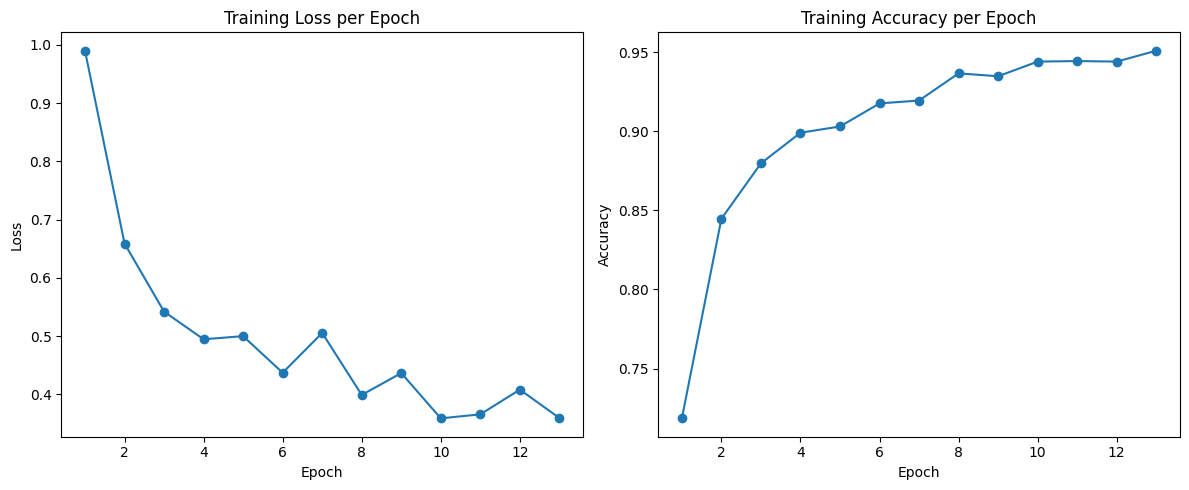

In [4]:
def plot_training_metrics(train_losses, train_accuracies, epochs):
    
    plt.figure(figsize=(12, 5))
    
    # Plotting training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, '-o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Plotting training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, '-o')
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    
plot_training_metrics(train_losses, train_accuracies, range(1, len(train_losses) + 1))

### Evaluation on Test data

In [5]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in (test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Get predictions and true labels
predictions, true_labels = evaluate_model(trained_model, test_loader)

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9060


### Loading ViT Model

In [6]:
model = models.vit_b_16(weights = models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)
model.heads.head = nn.Linear(in_features=model.heads.head.in_features, out_features=num_classes)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vit_b_16_lc_swag-4e70ced5.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_lc_swag-4e70ced5.pth
100%|██████████| 330M/330M [00:01<00:00, 227MB/s]


### Training of ViT model

In [7]:
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100)

Epoch 1/100, Train Loss: 1.6171, Train Accuracy: 0.4446, Val Loss: 0.8202, Val Accuracy: 0.6950
Epoch 2/100, Train Loss: 0.7877, Train Accuracy: 0.7243, Val Loss: 0.6361, Val Accuracy: 0.7678
Epoch 3/100, Train Loss: 0.7504, Train Accuracy: 0.7360, Val Loss: 0.5259, Val Accuracy: 0.8149
Epoch 4/100, Train Loss: 0.6289, Train Accuracy: 0.7813, Val Loss: 0.6181, Val Accuracy: 0.7708
Epoch 5/100, Train Loss: 0.5490, Train Accuracy: 0.8083, Val Loss: 0.5290, Val Accuracy: 0.8114
Epoch 6/100, Train Loss: 0.5480, Train Accuracy: 0.8093, Val Loss: 0.4867, Val Accuracy: 0.8324
Epoch 7/100, Train Loss: 0.6825, Train Accuracy: 0.7590, Val Loss: 0.5458, Val Accuracy: 0.8128
Epoch 8/100, Train Loss: 0.5478, Train Accuracy: 0.8090, Val Loss: 0.4400, Val Accuracy: 0.8525
Epoch 9/100, Train Loss: 0.4417, Train Accuracy: 0.8473, Val Loss: 0.4215, Val Accuracy: 0.8515
Epoch 10/100, Train Loss: 0.3904, Train Accuracy: 0.8637, Val Loss: 0.6008, Val Accuracy: 0.8092
Epoch 11/100, Train Loss: 0.5440, Train

### Visualizing ViT loss and accuracy

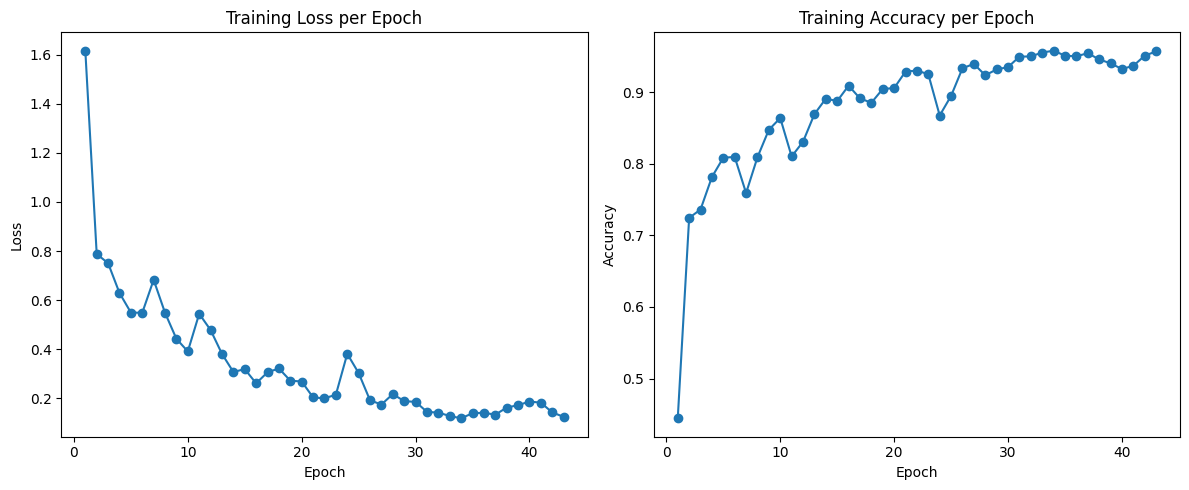

In [8]:
plot_training_metrics(train_losses, train_accuracies, range(1, len(train_losses) + 1))

### Evaluating ViT

In [9]:
# Get predictions and true labels
predictions, true_labels = evaluate_model(trained_model, test_loader)

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9540
